In [1]:
using HarmonicBalance

# Natural equation for the parametron

In [2]:
@variables Ω,γ,λ,F, x,θ,η,α, ω0, ω,t, ψ, T, x(t)

natural_equation =  d(d(x,t),t) + γ*d(x,t) + Ω^2*(1-λ*cos(2*ω*t+ψ))*x + α * x^3 + η *d(x,t) * x^2
forces =  F*cos(ω*t+θ)
dEOM = HarmonicBalance.DifferentialEquation(natural_equation + forces, x)
HarmonicBalance.add_harmonic!(dEOM, x, ω);
#HarmonicBalance.add_harmonic!(dEOM, x, 3*ω)

In [3]:
@time averagedEOM = HarmonicBalance.get_harmonic_equations(dEOM, slow_time=T, fast_time=t)

 98.545940 seconds (132.78 M allocations: 7.530 GiB, 2.74% gc time, 99.35% compilation time)


A set of 2 harmonic equations
Variables: u1(T), v1(T)
Parameters: α, ω, F, θ, γ, η, Ω, λ, ψ

Harmonic ansatz: 
x(t) = u1*cos(ωt) + v1*sin(ωt)

Harmonic equations:

F*cos(θ) + γ*Differential(T)(u1(T)) + (Ω^2)*u1(T) + (3//4)*α*(u1(T)^3) + γ*ω*v1(T) + (2//1)*ω*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^2)*u1(T) + (1//4)*η*ω*(v1(T)^3) + (3//4)*η*(u1(T)^2)*Differential(T)(u1(T)) + (1//4)*η*(v1(T)^2)*Differential(T)(u1(T)) + (1//4)*η*ω*(u1(T)^2)*v1(T) + (1//2)*η*u1(T)*v1(T)*Differential(T)(v1(T)) + (1//2)*λ*(Ω^2)*v1(T)*sin(ψ) - (ω^2)*u1(T) - (1//2)*λ*(Ω^2)*u1(T)*cos(ψ) ~ 0

(Ω^2)*v1(T) + γ*Differential(T)(v1(T)) + (3//4)*α*(v1(T)^3) + (1//4)*η*(u1(T)^2)*Differential(T)(v1(T)) + (3//4)*α*(u1(T)^2)*v1(T) + (3//4)*η*(v1(T)^2)*Differential(T)(v1(T)) + (1//2)*λ*(Ω^2)*u1(T)*sin(ψ) + (1//2)*λ*(Ω^2)*v1(T)*cos(ψ) + (1//2)*η*u1(T)*v1(T)*Differential(T)(u1(T)) - F*sin(θ) - (ω^2)*v1(T) - (2//1)*ω*Differential(T)(u1(T)) - (1//4)*η*ω*(u1(T)^3) - γ*ω*u1(T) - (1//4)*η*ω*(v1(T)^2)*u1(T) ~ 0


In [4]:
@time problem = HarmonicBalance.Problem(averagedEOM, explicit_Jacobian=true)

 13.160589 seconds (14.73 M allocations: 839.726 MiB, 2.21% gc time, 99.31% compilation time)


2 algebraic equations for steady states
Variables: u1, v1
Parameters: α, ω, F, θ, γ, η, Ω, λ, ψ
Symbolic Jacobian: true


## sweep parameters

In [5]:
fixed_parameters = (Ω => 1.0,γ => 1E-2, λ => 5E-2, F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0)
sweep = ω => LinRange(0.9, 1.1, 100)
#sweep = (ω => LinRange(0.9, 1.1,15), λ => LinRange(0.0, 0.2, 10))

soln = HarmonicBalance.get_steady_states(problem, sweep, fixed_parameters, random_warmup=true, threading=false)

Tracking 9 paths... 100%|███████████████████████████████| Time: 0:00:14
  # paths tracked:                  9
  # non-singular solutions (real):  5 (0)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         5 (0)


A steady state result for 100 parameter points

Solution branches:   5
   of which real:    5
   of which stable:  3

Classes: stable, physical, Hopf, binary_labels


In [6]:
HarmonicBalance.save("parametron_result.jld2", soln);

# making 1D plots

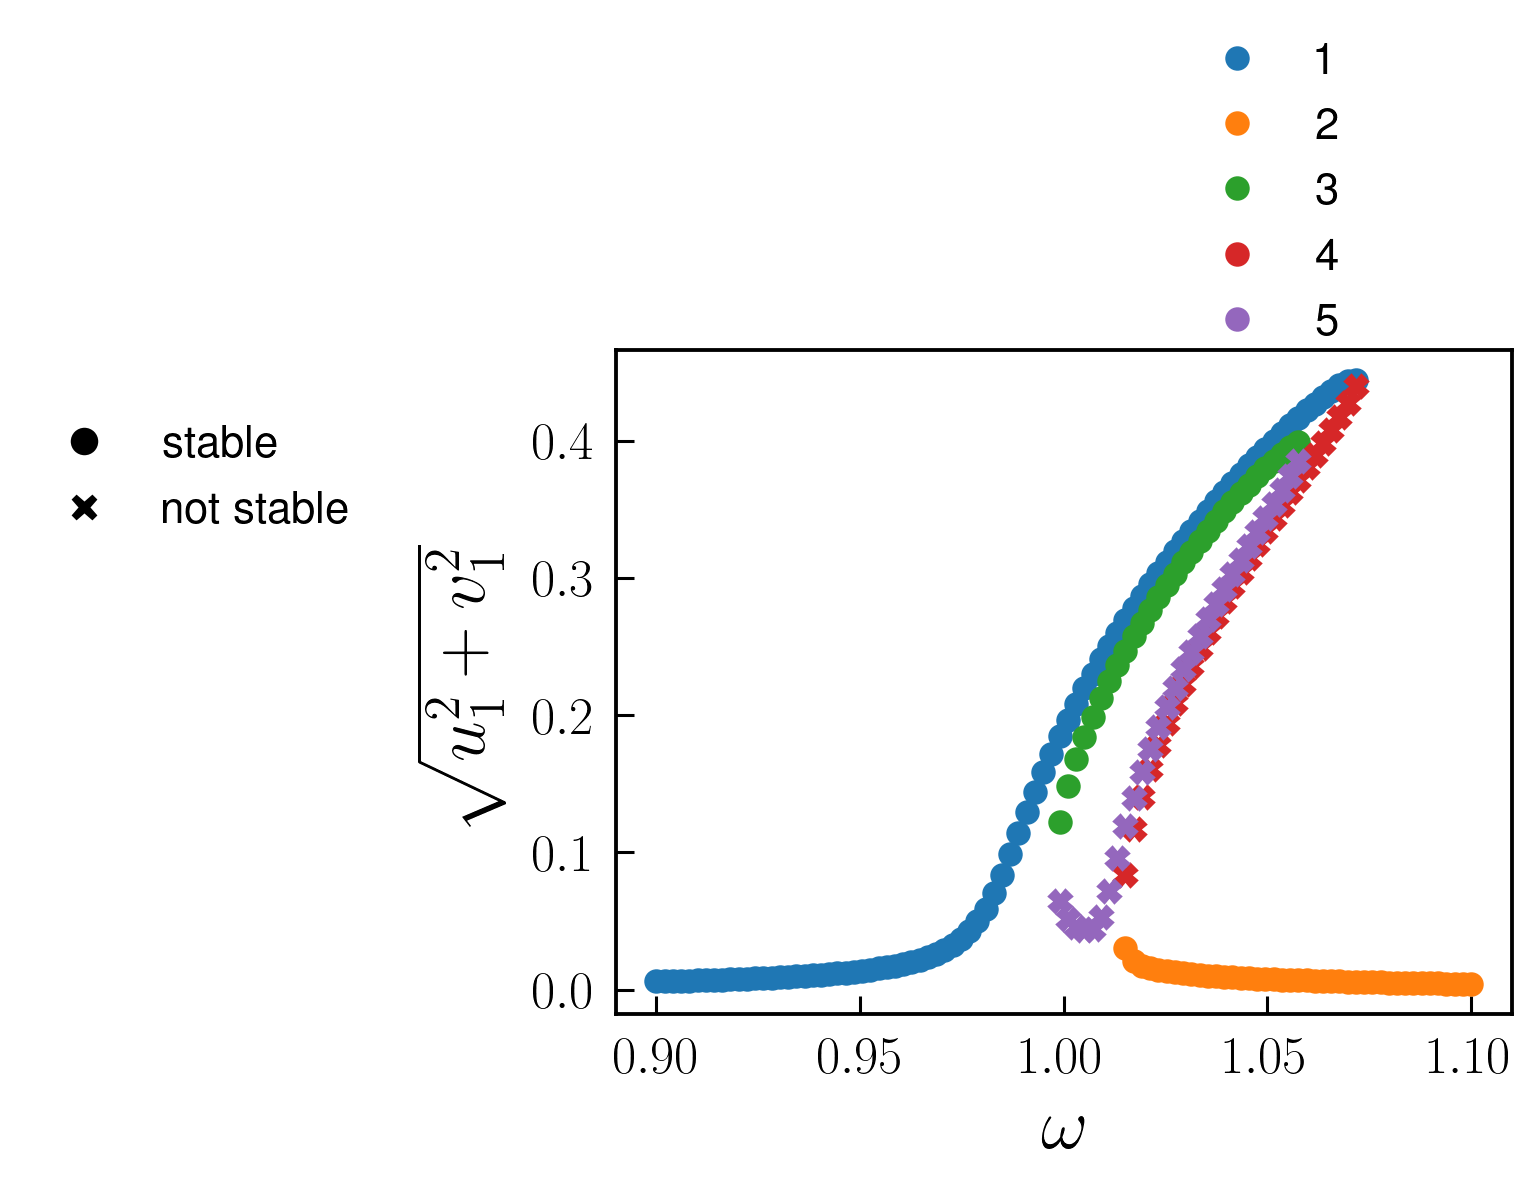

In [11]:
HarmonicBalance.plot_1D_solutions(soln, x="ω", y="sqrt(u1^2 + v1^2)", plot_only=["physical"], marker_classification="stable");

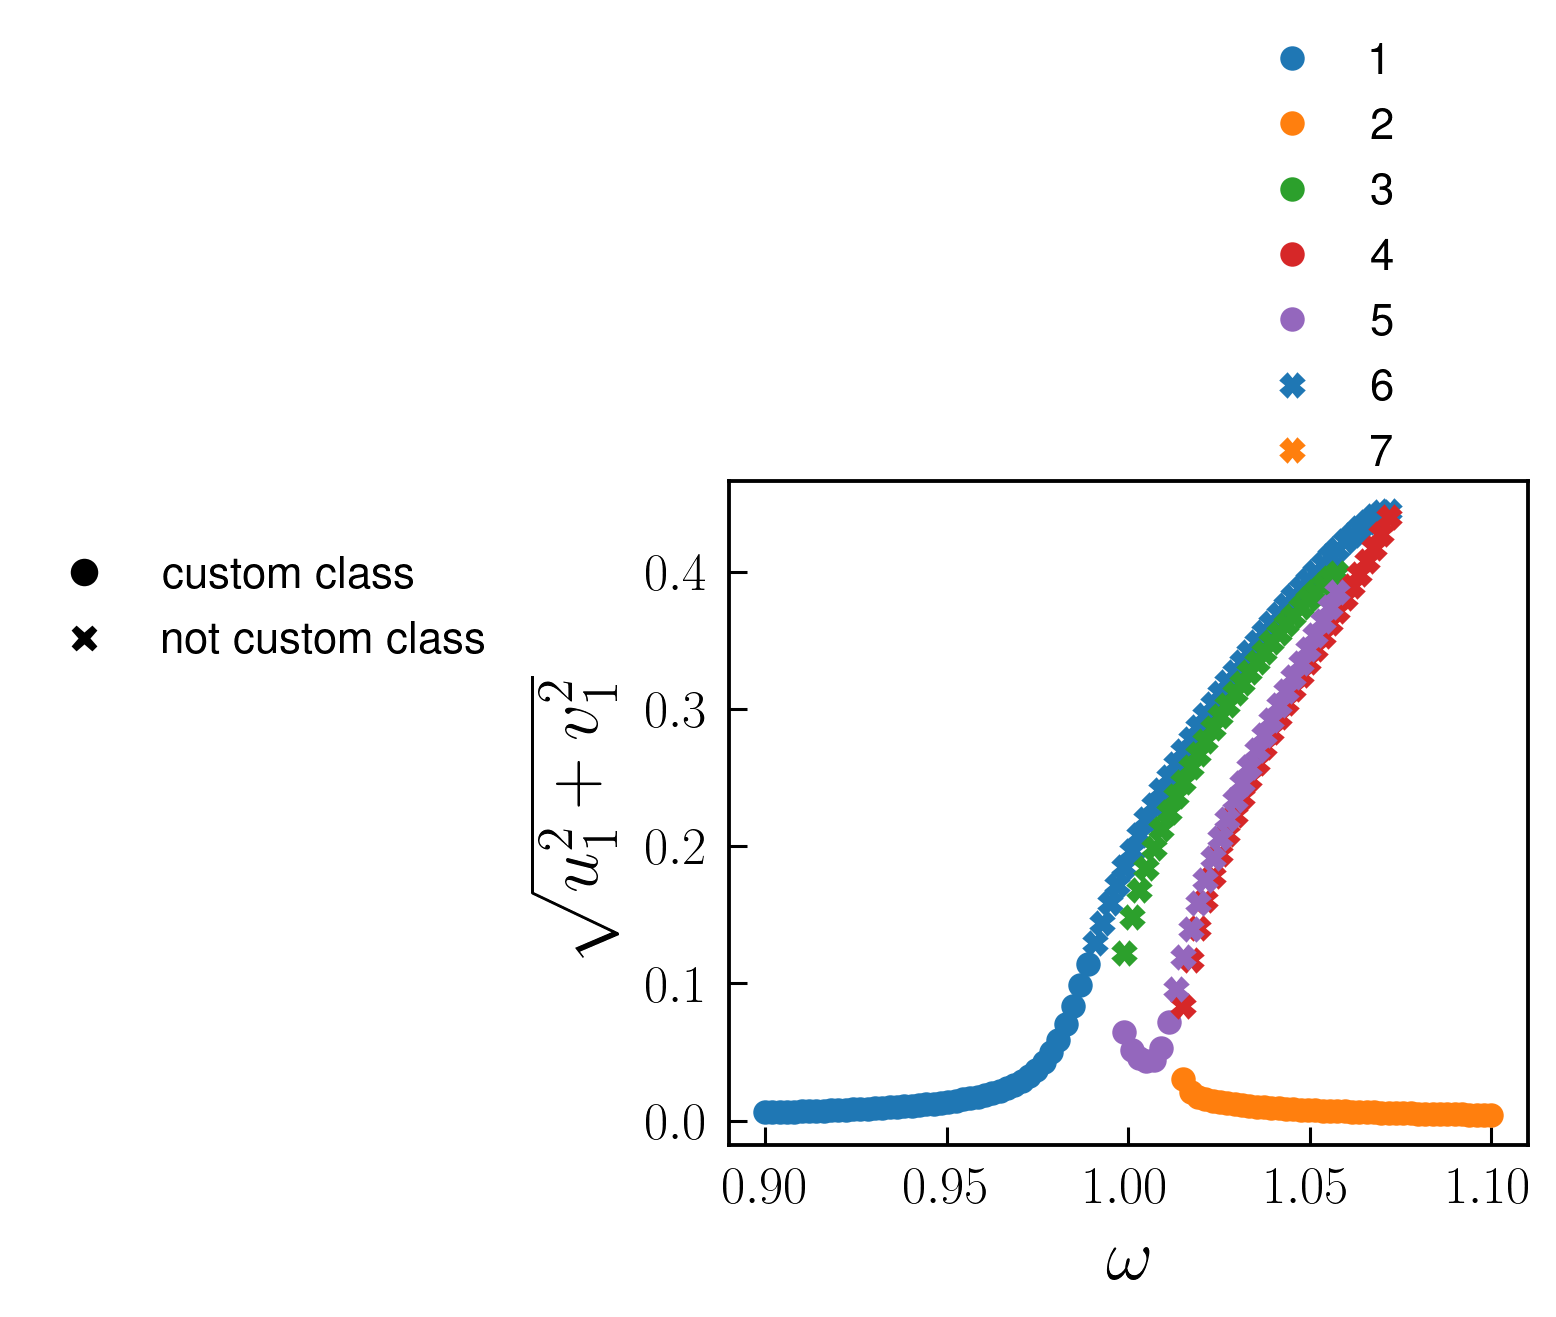

In [12]:
# user-allowed classification
plt = HarmonicBalance.plot_1D_solutions(soln, x="ω", y="sqrt(u1^2 + v1^2)", marker_classification="ω^15 * sqrt(u1^2 + v1^2) < 0.1")

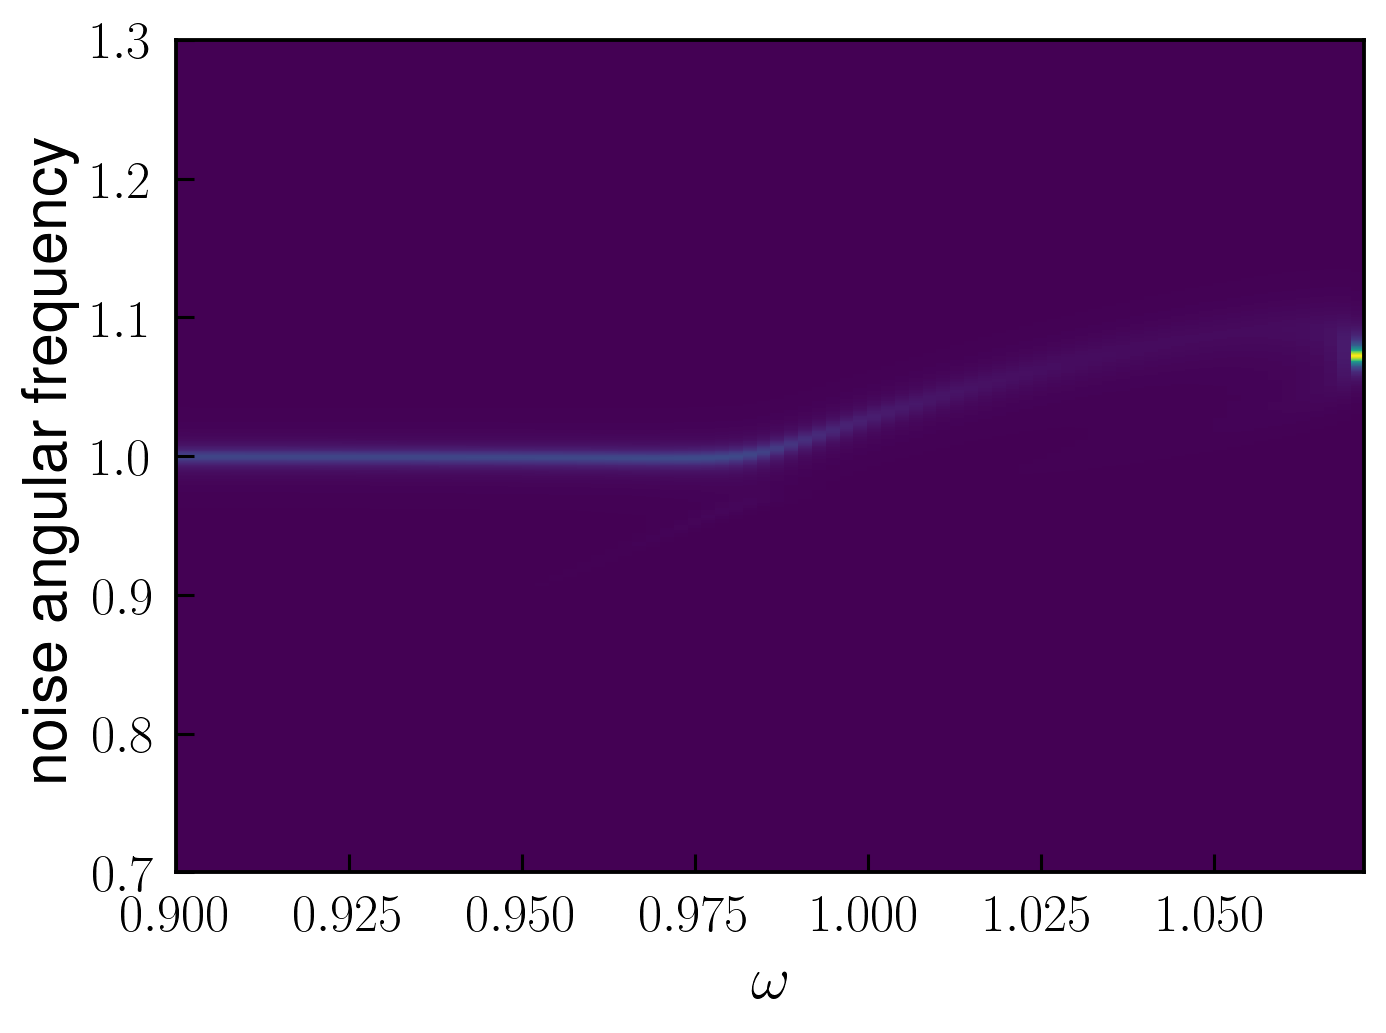

 23.007783 seconds (69.48 M allocations: 3.243 GiB, 4.63% gc time, 69.62% compilation time)


In [9]:
@time HarmonicBalance.LinearResponse.plot_response(soln, LinRange(0.7,1.3,1000), branch=1, logscale=false);

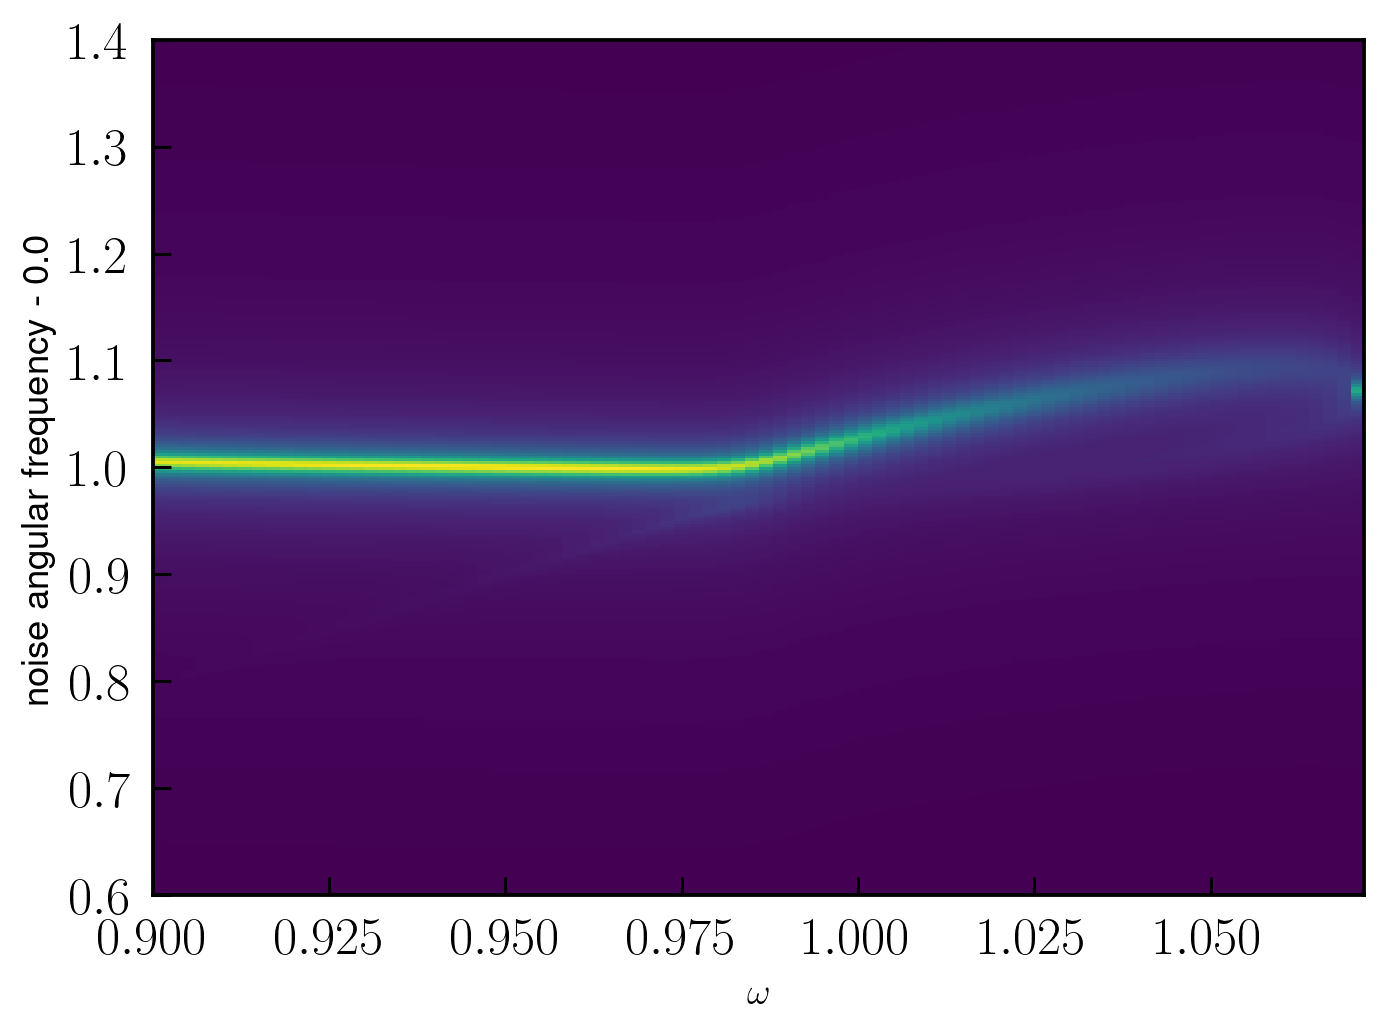

  2.982632 seconds (5.58 M allocations: 326.601 MiB, 5.10% gc time, 98.59% compilation time)


In [10]:
@time spectrum = HarmonicBalance.LinearResponse.plot_jacobian_spectrum(soln, x, branch=1, Ω_range=LinRange(0.6,1.4,300));

# time-dependent solving

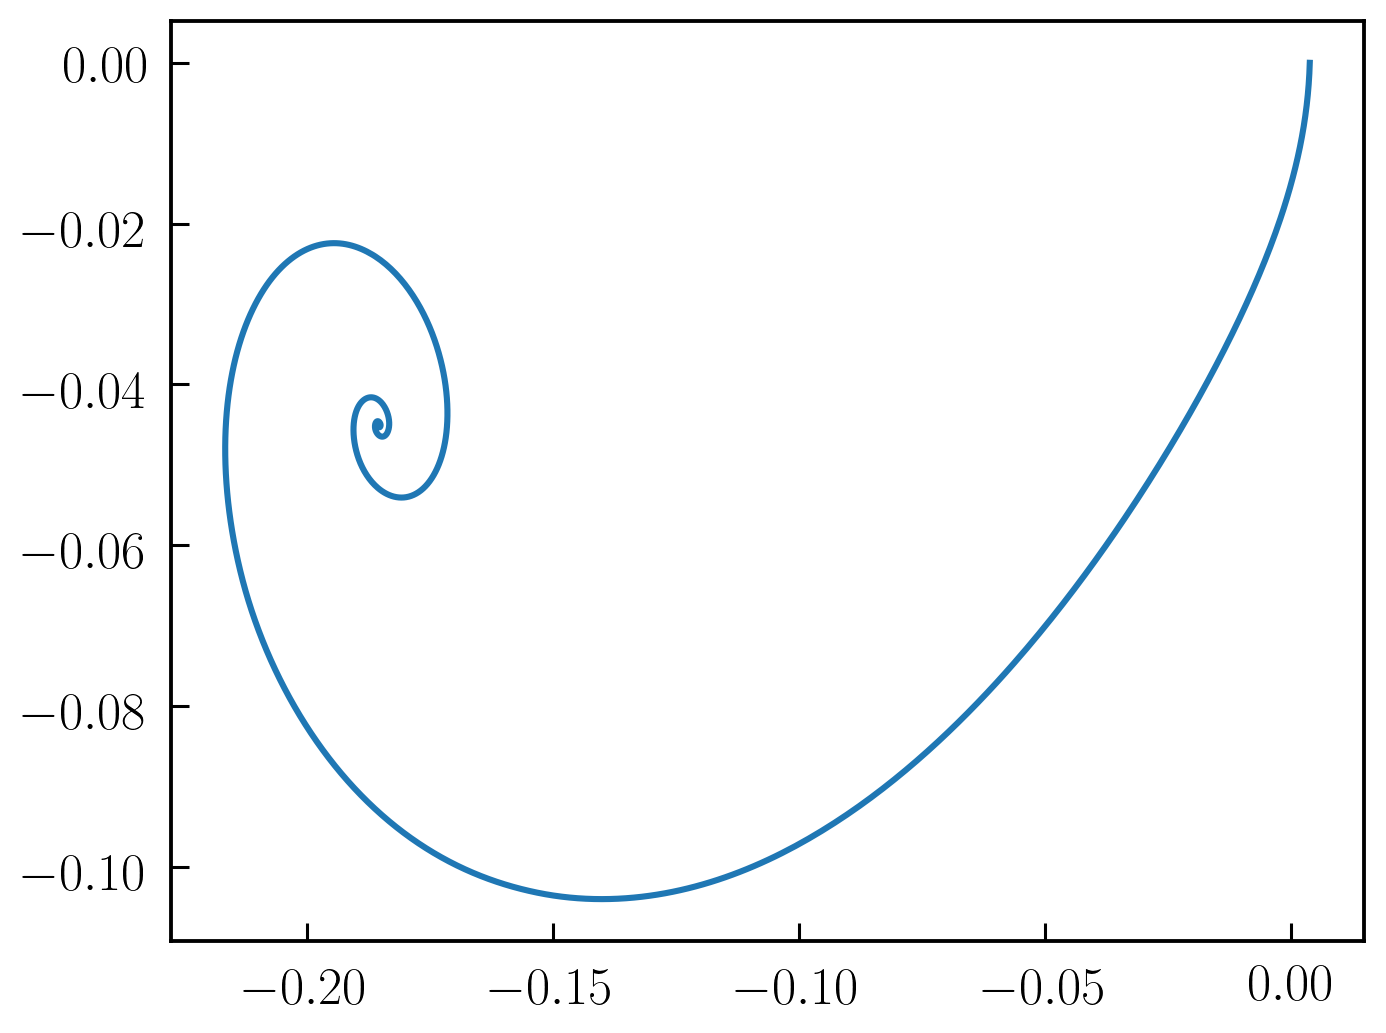

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f89fec3e190>

In [23]:
x0 = [0.0037178842249515134; 0.]
times = (0.,1000.)
dt = 1. # time-resolution of the result (NOT the integration timestep)
fixed_parameters = ParameterList(Ω => 1.0,γ => 1E-2, λ => 5E-2, F => 1E-3,  α => 1., η=>0.3, θ => 0, ψ => 0, ω=>1.)
time_dep = HarmonicBalance.TimeEvolution.ODEProblem(averagedEOM, fixed_parameters, sweep=HarmonicBalance.TimeEvolution.ParameterSweep(), x0 = x0, timespan = times);
time_soln = HarmonicBalance.TimeEvolution.solve(time_dep, saveat=dt);
HarmonicBalance.plot(getindex.(time_soln.u, 1), getindex.(time_soln.u,2))